In [101]:
#import 
from models.vae import *
import pickle
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import os
from data_generation.geom_utils import graph_distance
from settings.custom_settings import CustomSettings
from data_generation.generate_trajectory import Trajectory
from data_generation.spatial_firing import gaussian
from mpl_toolkits.mplot3d import axes3d
from training.train_ae import preprocessing
import pandas as pd
from matplotlib.path import Path
import matplotlib.patches as patches
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [102]:
LATENT_SPACE_DIM = 3 

MODEL_PATH = "./saved_models/vae_eucl_exp17_b10_l4"
EXP_NAME = "experiment17"  

In [103]:
#Load data and model
#TODO use better data structure

#GRAPH
with open(MODEL_PATH + '/test_data', 'rb') as file:
    X_test = pickle.load(file)
with open(MODEL_PATH + '/train_data', 'rb') as file:
    X_train = pickle.load(file)
with open(MODEL_PATH + '/nonoise_test_data', 'rb') as file:
    X_n_test = pickle.load(file)
with open(MODEL_PATH + '/nonoise_train_data', 'rb') as file:
    X_n_train = pickle.load(file)
with open(MODEL_PATH + "/test_data_traj", 'rb') as file:
    traj_test = pickle.load(file)
with open(MODEL_PATH + "/train_data_traj", 'rb') as file:
    traj_train = pickle.load(file)
with open(MODEL_PATH + "/test_maze_config", 'rb') as file:
    test_maze_config = pickle.load(file)
with open(MODEL_PATH + "/train_maze_config", 'rb') as file:
    train_maze_config = pickle.load(file)
with open(MODEL_PATH + "/train_edge", 'rb') as file:
    train_edge = pickle.load(file)
with open(MODEL_PATH + "/test_edge", 'rb') as file:
    test_edge = pickle.load(file)


path = "./data_generation/generated_data/" + EXP_NAME
with open(path + "/maze.pkl", 'rb') as file:
    maze = pickle.load(file) #Maze is common to both
with open(path + "/trajectory.pkl", 'rb') as file:
    traj = pickle.load(file)
with open(path + "/placeCells.pkl", 'rb') as file:
    placeCells = pickle.load(file)



In [104]:
#load model
with open(MODEL_PATH + "/model", 'rb') as file:
    model = pickle.load(file)
with open(MODEL_PATH + "/prep", 'rb') as file:
    prep = pickle.load(file)

model.eval()

VAE(
  (encoder_layers): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (linear1): Linear(in_features=8, out_features=3, bias=True)
  (linear2): Linear(in_features=8, out_features=3, bias=True)
  (decoder_layers): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8

In [105]:
mu, logvar = model.encoder(X_train)
#mu = mu.detach().numpy()

In [110]:
p= torch.Tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0.1], [0.1, 0, 0], [0, 0.1, -0.1]]) #choose a poing in latent space
S_gen = model.decoder(p).detach().numpy()


In [111]:
idx = np.argsort(S_gen)[:, -6:]

In [112]:
c = placeCells.fieldCenters[:, idx, 0]

In [113]:
c.shape

(2, 5, 6)

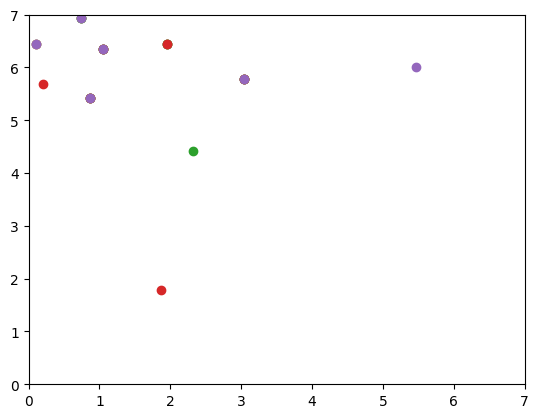

In [114]:
plt.figure()

for i in range(c.shape[1]):
    plt.xlim([0,7])
    plt.ylim([0,7])
    plt.scatter(c[0, i, :], c[1, i, :])
plt.show()

In [115]:
c_tot = placeCells.fieldCenters[:, :, 0] 

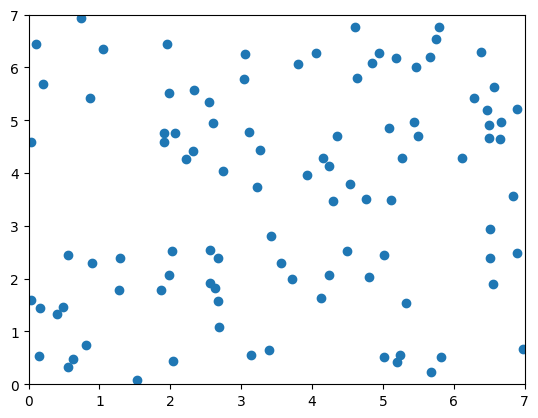

In [116]:
plt.figure()

plt.xlim([0,7])
plt.ylim([0,7])
plt.scatter(c_tot[0, :], c_tot[1, :])
plt.show()

In [101]:
def inv_gaussian(fx, std, p_max):
    d = np.sqrt(-2*np.log(fx/p_max))*std
    return d

In [102]:
d = inv_gaussian(S_gen, placeCells.std, placeCells.nu_max)

In [125]:
np.sort(placeCells.fieldCenters, axis =1)[:, -3:, 0]

array([[6.83, 6.83, 6.85],
       [6.74, 6.77, 6.96]])

In [119]:
from sympy import symbols, Eq, solve
c = np.sort(placeCells.fieldCenters, axis =1)[:, -4:, 0]


x, y = symbols("x y")
equation_1 = Eq((c[0, 0] - x)**2 + (c[1, 0]- y)**2, d[0, 0]**2)
equation_2 = Eq((c[0, 1] - x)**2 + (c[1, 1]- y)**2, d[0, 1]**2)
equation_3 = Eq((c[0, 2] - x)**2 + (c[1, 2]- y)**2, d[0, 2]**2)
print("Equation 1:", equation_1)
print("Equation 2:", equation_2)
print("Equation 3:", equation_3)
solution = solve((equation_1, equation_2), (x, y))
print("Solution:", solution)


Equation 1: Eq((0.03 - y)**2 + (0.05 - x)**2, 0.653469082143378)
Equation 2: Eq((0.11 - y)**2 + (0.19 - x)**2, 3.3742392584827)
Equation 3: Eq((0.33 - y)**2 + (0.47 - x)**2, 2.17919138315716)
Solution: [(-7.20515047475971 - 4.12635504550039*I, -4.11580027129126 + 7.22112132962568*I), (-7.20515047475971 + 4.12635504550039*I, -4.11580027129126 - 7.22112132962568*I)]


In [83]:
traj_train

array([[2.63716185, 5.63216744],
       [3.91      , 3.5       ],
       [4.54465079, 4.54465079],
       ...,
       [2.09806133, 4.90193867],
       [6.21008622, 5.21008622],
       [2.35969083, 2.35969083]])